This notebook aims to augment the already existing pre-trained word embeddings online which maybe GloVe, Word2Vec etc, which are generalized word embeddings together with the generated hate_speech_dataset which aims to leverage these existing word embeddings to generate new word embeddings for these new words in the hate_speech_dataset which may not Exist in the vocabulary of these word embeddings themselves

# Import Libraries

In [121]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import one_hot

from utilities.data_loaders import data_split_metric_values
from utilities.data_preprocessors import read_preprocess, shuffle_data, series_to_1D_array, construct_embedding_dict, construct_embedding_matrix
from utilities.data_visualizers import train_cross_results_v2, view_final_metrics, multi_class_heatmap, view_metric_values, view_classified_labels
from models.model_arcs import load_lstm_model

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [122]:
# 1 for religious and 0 for non religious
df = pd.read_csv('./data/hate-speech-data-cleaned.csv', index_col=0)
df = shuffle_data(read_preprocess(df))

df['label'].value_counts()

2    22395
1    21644
0    19743
3     1998
Name: label, dtype: int64

In [123]:
all_words = pd.Series(series_to_1D_array(df['comment']))
all_unique_words_counts = all_words.value_counts()
all_unique_words = all_words.unique()

In [124]:
len(all_words)

894878

In [125]:
len(all_unique_words)

47921

In [126]:
all_unique_words_counts

nigger               16186
faggot               14812
bitch                12246
tranny               11850
like                 11657
                     ...  
prototype                1
pooci                    1
antimale                 1
dickchickstarwars        1
nitty                    1
Length: 47921, dtype: int64

In [127]:
# before joining again get array in df with longest length first
max_len_1 = len(max(df['comment'], key=len))
type(max_len_1)

int

In [128]:
max_len_1

503

# Details about the dataframe
in summary classes are now to be the ff:
- NEITHER 1
- OFFENSIVE 0
- HATE 2
- HOMONYM 3

In [129]:
df['comment'] = df['comment'].apply(lambda comment: " ".join(comment))
df

,comment,label
0,michelle fuck obama tranny dick bitch,2
1,bitch screaming fuck nigga get mad another bit...,0
2,movie catch young older got gi jane wonder man...,2
3,like bitch u aint first place,0
4,got first time eating dick made someone faggot,2
...,...,...
65775,gtgirls guy tranniesis anyone wont bed hey com...,1
65776,bro rippin apart bird foot u redtail hawk,1
65777,gorillaz like two hit wonder edit three hit wo...,2
65778,goat nitty bitch rubbin beard stomach time jol...,0


In [130]:
df.loc[0, 'comment']

'michelle fuck obama tranny dick bitch'

In [131]:
df['label'].value_counts()

2    22395
1    21644
0    19743
3     1998
Name: label, dtype: int64

# Preparing data for training classifier
**A note on the subsequent code below**

fit_on_texts Updates internal vocabulary based on a list of texts. This method creates the vocabulary index based on word frequency. So if you give it something like, "The cat sat on the mat." It will create a dictionary s.t. word_index["the"] = 1; word_index["cat"] = 2 it is word -> index dictionary so every word gets a unique integer value. 0 is reserved for padding. So lower integer means more frequent word (often the first few are stop words because they appear a lot).

texts_to_sequences Transforms each text in texts to a sequence of integers. So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary. Nothing more, nothing less, certainly no magic involved.

In [132]:
sents = df['comment']
max_len_2 = 50

num_words_1 = df.shape[0]
num_words_2 = len(all_words)
num_words_3 = len(all_unique_words)

tokenizer = Tokenizer(num_words=num_words_3, split=' ')
tokenizer.fit_on_texts(sents)
# the bug is here that's why there are wrong indeces

seqs = tokenizer.texts_to_sequences(sents)

# post means place padding of 0's on the tail or ending of the sequence
# and truncating removes the values of a sequence that is greater than the max length given
seqs_padded = pad_sequences(seqs, maxlen=max_len_2, padding='post', truncating='post')

In [133]:
# at the same time one hot encode the y labels/classes
# and retrieve the number of unique labels of y
unique_labels = df['label'].unique()
len_unique_labels = len(unique_labels)
Y_oh = one_hot(df['label'], len_unique_labels).numpy()
Y_oh

array([[0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [134]:
seqs

[[1126, 12, 289, 4, 78, 3],
 [3, 1007, 12, 37, 8, 320, 141, 3, 12, 37],
 [411,
  816,
  503,
  1053,
  24,
  11288,
  5987,
  537,
  130,
  49,
  125,
  914,
  1301,
  2,
  3,
  1082,
  4977,
  60,
  975],
 [5, 3, 26, 79, 101, 186],
 [24, 101, 20, 748, 78, 117, 31, 2],
 [1907,
  1383,
  1165,
  327,
  83,
  142,
  158,
  9,
  1316,
  7121,
  2,
  29,
  21,
  96,
  429,
  366,
  25],
 [4007, 44, 103, 12, 103, 11, 134, 12, 988, 2, 5195, 1062, 15, 18, 1062],
 [21627, 7655, 21628, 9989, 1016, 100, 95, 1041, 1763, 1183, 1],
 [79, 24, 13072, 3, 33, 5],
 [21629, 8250, 211, 5, 273, 21630, 3056, 295, 76, 8251, 21631],
 [13073, 3483, 127, 13074, 2289, 268, 13075, 330, 459, 109, 26, 18, 2787, 2],
 [665, 30, 4978, 1, 1394, 273, 407],
 [281, 477, 39, 5, 2725, 2535, 2535, 285, 1113, 3, 296],
 [22, 330, 3, 27],
 [335, 13, 7122, 9990, 7, 152, 7, 829, 13, 662, 26, 73, 66],
 [13076,
  1166,
  216,
  1807,
  1533,
  21632,
  289,
  902,
  4,
  92,
  92,
  1522,
  901,
  289,
  1364,
  355,
  533,
  1364,

Here we see that indeed 50 is not enough as our max length but for the subsequent code we will still use 50 and later 503 for our experimentation. For now 503 will be an extremely large value eespecially when applied to all sequences

In [135]:
print(max_len_1, max_len_2)

503 50


In [136]:
word_to_index = tokenizer.word_index
index_to_word = tokenizer.index_word
print(len(word_to_index))

47916


In [137]:
word_to_index

{'nigger': 1,
 'faggot': 2,
 'bitch': 3,
 'tranny': 4,
 'like': 5,
 'people': 6,
 'would': 7,
 'get': 8,
 'word': 9,
 'say': 10,
 'one': 11,
 'fuck': 12,
 'hoe': 13,
 'black': 14,
 'shit': 15,
 'know': 16,
 'think': 17,
 'fucking': 18,
 'call': 19,
 'time': 20,
 'guy': 21,
 'make': 22,
 'white': 23,
 'got': 24,
 'gay': 25,
 'u': 26,
 'want': 27,
 'even': 28,
 'go': 29,
 'called': 30,
 'someone': 31,
 'really': 32,
 'thing': 33,
 'said': 34,
 'pussy': 35,
 'as': 36,
 'nigga': 37,
 'use': 38,
 'look': 39,
 'right': 40,
 'trannies': 41,
 'woman': 42,
 'see': 43,
 'saying': 44,
 'racist': 45,
 'man': 46,
 'way': 47,
 'cannot': 48,
 'good': 49,
 'calling': 50,
 'mean': 51,
 'still': 52,
 'never': 53,
 'also': 54,
 'lol': 55,
 'person': 56,
 'hate': 57,
 'much': 58,
 'need': 59,
 'could': 60,
 'going': 61,
 'used': 62,
 'love': 63,
 'back': 64,
 'year': 65,
 'day': 66,
 'girl': 67,
 'something': 68,
 'well': 69,
 'op': 70,
 'friend': 71,
 'bad': 72,
 'every': 73,
 'let': 74,
 'actually': 75,

In [138]:
index_to_word

{1: 'nigger',
 2: 'faggot',
 3: 'bitch',
 4: 'tranny',
 5: 'like',
 6: 'people',
 7: 'would',
 8: 'get',
 9: 'word',
 10: 'say',
 11: 'one',
 12: 'fuck',
 13: 'hoe',
 14: 'black',
 15: 'shit',
 16: 'know',
 17: 'think',
 18: 'fucking',
 19: 'call',
 20: 'time',
 21: 'guy',
 22: 'make',
 23: 'white',
 24: 'got',
 25: 'gay',
 26: 'u',
 27: 'want',
 28: 'even',
 29: 'go',
 30: 'called',
 31: 'someone',
 32: 'really',
 33: 'thing',
 34: 'said',
 35: 'pussy',
 36: 'as',
 37: 'nigga',
 38: 'use',
 39: 'look',
 40: 'right',
 41: 'trannies',
 42: 'woman',
 43: 'see',
 44: 'saying',
 45: 'racist',
 46: 'man',
 47: 'way',
 48: 'cannot',
 49: 'good',
 50: 'calling',
 51: 'mean',
 52: 'still',
 53: 'never',
 54: 'also',
 55: 'lol',
 56: 'person',
 57: 'hate',
 58: 'much',
 59: 'need',
 60: 'could',
 61: 'going',
 62: 'used',
 63: 'love',
 64: 'back',
 65: 'year',
 66: 'day',
 67: 'girl',
 68: 'something',
 69: 'well',
 70: 'op',
 71: 'friend',
 72: 'bad',
 73: 'every',
 74: 'let',
 75: 'actually',

In [139]:
seqs[0]

[1126, 12, 289, 4, 78, 3]

In [140]:
# this is supposed to be 1301
print(word_to_index['complain'])

# this is supposed to be 3583
print(word_to_index['cleaning'])

1302
3591


In [141]:
seqs_padded

array([[ 1126,    12,   289, ...,     0,     0,     0],
       [    3,  1007,    12, ...,     0,     0,     0],
       [  411,   816,   503, ...,     0,     0,     0],
       ...,
       [20722,     5,   146, ...,     0,     0,     0],
       [ 2472, 47916,     3, ...,     0,     0,     0],
       [    2,   118,    92, ...,     0,     0,     0]])

In [142]:
train_seqs, _seqs, train_labels, _labels = train_test_split(seqs_padded, Y_oh, test_size=0.3, random_state=0)
val_seqs, test_seqs, val_labels, test_labels = train_test_split(_seqs, _labels, test_size=0.5, random_state=0)

train_seqs

array([[ 75, 281, 903, ...,   0,   0,   0],
       [ 60, 134, 205, ...,   0,   0,   0],
       [ 95, 599, 294, ...,   0,   0,   0],
       ...,
       [ 20,  19,  13, ...,   0,   0,   0],
       [303,  17,   1, ...,   0,   0,   0],
       [436, 117, 118, ...,   0,   0,   0]])

In [143]:
train_seqs.shape

(46046, 50)

In [144]:
val_seqs

array([[   94,   619,     5, ...,     0,     0,     0],
       [   56,  4467,   398, ...,     0,     0,     0],
       [  113,    84,    95, ...,     0,     0,     0],
       ...,
       [  144,    77,     5, ...,     0,     0,     0],
       [ 4232,    47,   365, ...,     0,     0,     0],
       [    8,  4595, 28712, ...,     0,     0,     0]])

In [145]:
len(val_seqs)

9867

# Loading the Big Guns 
or the 1.9 million word vocabulary and its 300 dimensional embeddings

In [146]:
# important variables

# includes oov words
vocab_len = len(word_to_index) + 1
emb_dict, emb_vec_len = construct_embedding_dict('./embeddings/glove.42B.300d.txt', word_to_index)
emb_matrix = construct_embedding_matrix(word_to_index, emb_dict, emb_vec_len)
lstm_model = load_lstm_model(max_len_2, vocab_len, emb_matrix)

100%|██████████| 47916/47916 [00:00<00:00, 155666.82it/s]


input shape: 50


In [147]:
lstm_model.summary()

Model: "hate-speech-lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 50, 300)           14375100  
                                                                 
 bidirectional_6 (Bidirectio  (None, 50, 32)           40576     
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 50, 32)            0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 32)           

In [148]:
len(emb_dict)

36132

In [149]:
emb_matrix.shape

(47917, 300)

In [150]:
lstm_history = lstm_model.fit(
    train_seqs, train_labels,
    batch_size=128,
    epochs=10,
    validation_data=(val_seqs, val_labels),
)

# build the dictionary of results based on metric history of both models
lstm_results = {}
for metric in ['loss', 'categorical_crossentropy', 'categorical_accuracy', 'val_loss', 'val_categorical_crossentropy', 'val_categorical_accuracy']:
    if metric not in lstm_results:
        lstm_results[metric] = lstm_history.history[metric]

Epoch 1/10
360/360 [==============================] - 56s 110ms/step - loss: 0.7063 - categorical_crossentropy: 0.7063 - categorical_accuracy: 0.7272 - val_loss: 0.5056 - val_categorical_crossentropy: 0.5056 - val_categorical_accuracy: 0.8175
Epoch 2/10
360/360 [==============================] - 36s 100ms/step - loss: 0.5263 - categorical_crossentropy: 0.5263 - categorical_accuracy: 0.8167 - val_loss: 0.4709 - val_categorical_crossentropy: 0.4709 - val_categorical_accuracy: 0.8273
Epoch 3/10
360/360 [==============================] - 36s 100ms/step - loss: 0.4896 - categorical_crossentropy: 0.4896 - categorical_accuracy: 0.8302 - val_loss: 0.4724 - val_categorical_crossentropy: 0.4724 - val_categorical_accuracy: 0.8266
Epoch 4/10
360/360 [==============================] - 37s 104ms/step - loss: 0.4663 - categorical_crossentropy: 0.4663 - categorical_accuracy: 0.8369 - val_loss: 0.4443 - val_categorical_crossentropy: 0.4443 - val_categorical_accuracy: 0.8378
Epoch 5/10
360/360 [========

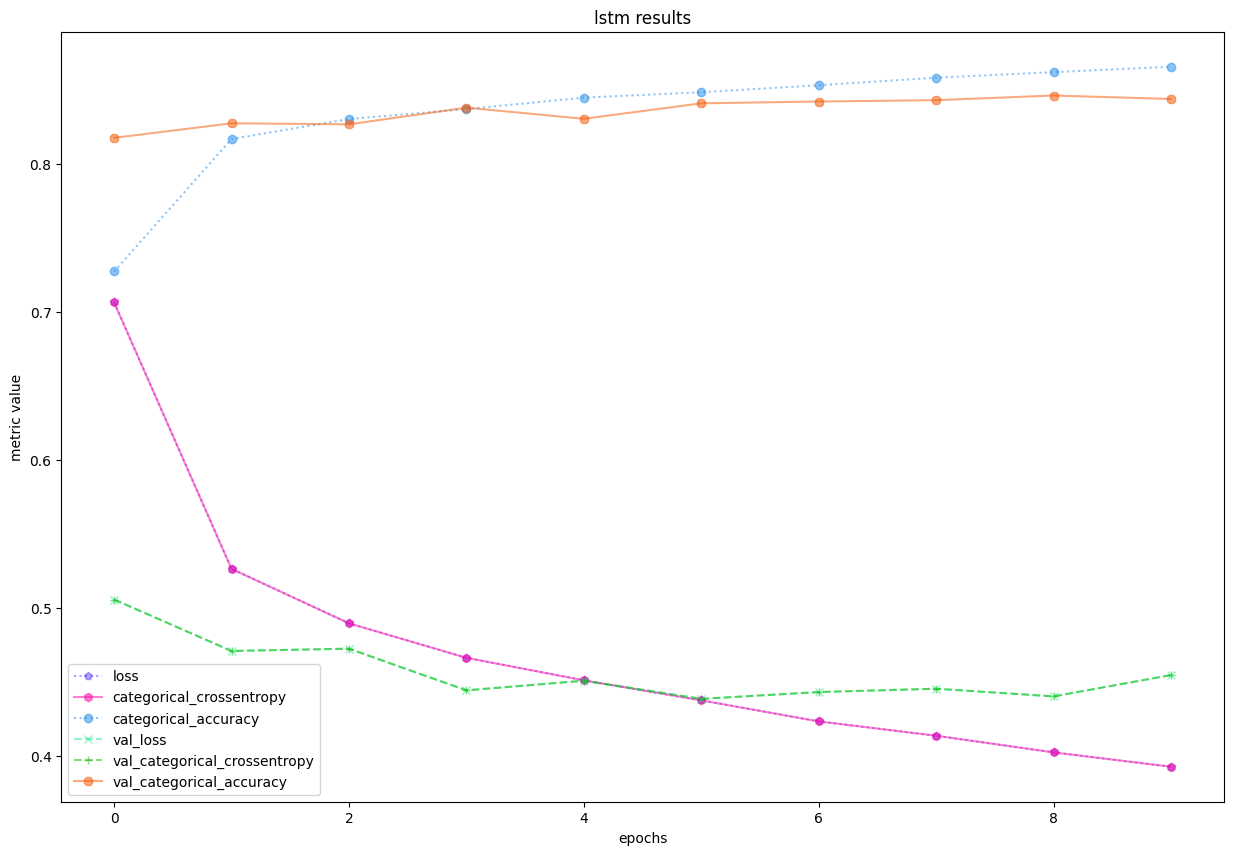

In [151]:
train_cross_results_v2(lstm_results, epochs=lstm_history.epoch, img_title='lstm results')

In [152]:
# display values from last epoch of baseline model
view_final_metrics(lstm_results, 'LSTM NEURAL NETWORK RESULTS')


LSTM NEURAL NETWORK RESULTS:
loss: 0.3926987051963806
categorical_crossentropy: 0.3926987051963806
categorical_accuracy: 0.8655040860176086
val_loss: 0.4545970559120178
val_categorical_crossentropy: 0.4545970559120178
val_categorical_accuracy: 0.8437215089797974


# Calculating main metric values for training, validation, and testing set e.g. Accuracy, Precision, Recall, F1-Score

In [153]:
# predict probabilities for training set
Y_pred_train = lstm_model.predict(train_seqs).argmax(axis=1)
Y_true_train = train_labels.argmax(axis=1)

# predict probabilities for validation set
Y_pred_val = lstm_model.predict(val_seqs).argmax(axis=1)
Y_true_val = val_labels.argmax(axis=1)

# predict probabilities for testing set
Y_pred_test = lstm_model.predict(test_seqs).argmax(axis=1)
Y_true_test = test_labels.argmax(axis=1)

309/309 [==============================] - 4s 14ms/step


In [154]:
# calculate accuracy, precision, recall, and f1-score for every data split
train_acc, train_prec, train_rec, train_f1 = data_split_metric_values(Y_true_train, Y_pred_train)
val_acc, val_prec, val_rec, val_f1 = data_split_metric_values(Y_true_val, Y_pred_val)
test_acc, test_prec, test_rec, test_f1 = data_split_metric_values(Y_true_test, Y_pred_test)

metrics_df = pd.DataFrame({
    'data_split': ['training', 'validation', 'testing'],
    'accuracy': [train_acc, val_acc, test_acc], 
    'precision': [train_prec, val_prec, test_prec], 
    'recall': [train_rec, val_rec, test_rec], 
    'f1-score': [train_f1, val_f1, test_f1]})

Accuracy: 87.55%
Precision: 87.80%
Recall: 87.55%
F1 score: 87.61%

Accuracy: 84.37%
Precision: 84.78%
Recall: 84.37%
F1 score: 84.48%

Accuracy: 84.74%
Precision: 85.09%
Recall: 84.74%
F1 score: 84.83%



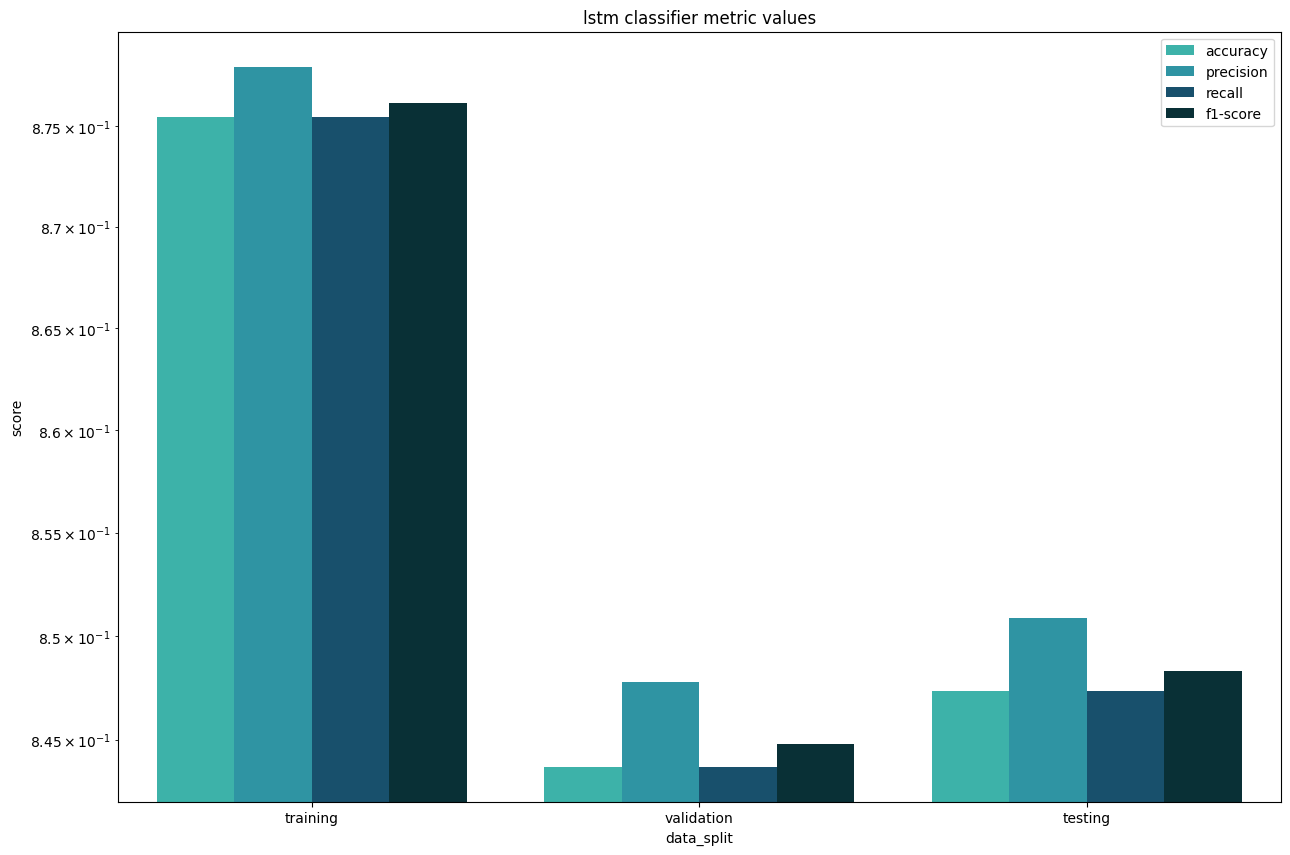

In [155]:
# visualize values of calculated metric value for each data split
view_metric_values(metrics_df, 'lstm classifier metric values')

# Confusion matrices for training, validation, and testing sets

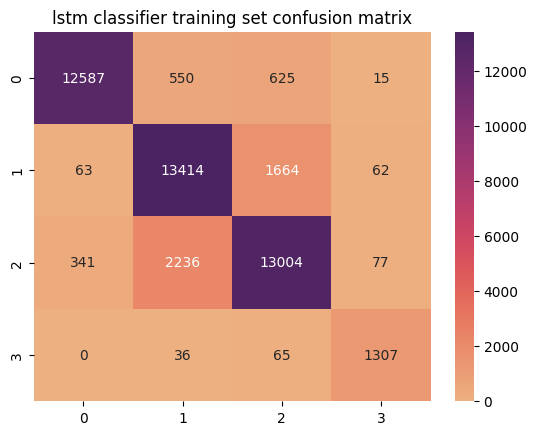

In [156]:
conf_matrix_train = confusion_matrix(Y_true_train, Y_pred_train, labels=np.unique(Y_true_train))
multi_class_heatmap(conf_matrix_train, 'lstm classifier training set confusion matrix', cmap='flare')

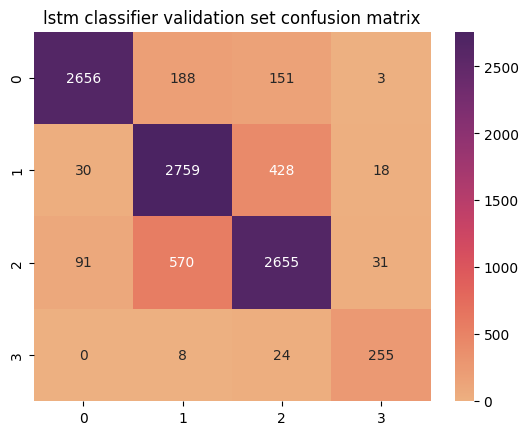

In [157]:
conf_matrix_val = confusion_matrix(Y_true_val, Y_pred_val, labels=np.unique(Y_true_val))
multi_class_heatmap(conf_matrix_val, 'lstm classifier validation set confusion matrix', cmap='flare')

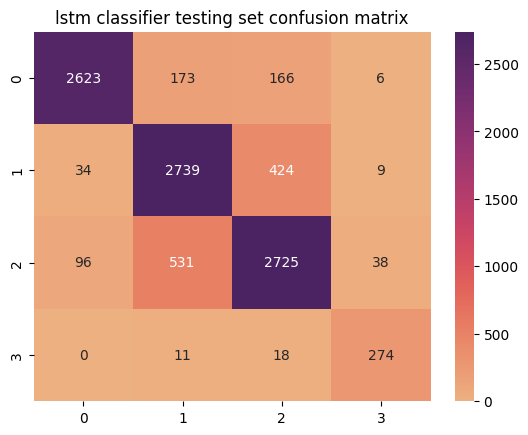

In [158]:
conf_matrix_test = confusion_matrix(Y_true_test, Y_pred_test, labels=np.unique(Y_true_test))
multi_class_heatmap(conf_matrix_test, 'lstm classifier testing set confusion matrix', cmap='flare')

In [159]:
# calculating all misclassified vs classified labels for training, validation, and testing sets
num_right_cm_train = conf_matrix_train.trace()
num_right_cm_val = conf_matrix_val.trace()
num_right_cm_test = conf_matrix_test.trace()

num_wrong_cm_train = train_labels.shape[0] - num_right_cm_train
num_wrong_cm_val = val_labels.shape[0] - num_right_cm_val
num_wrong_cm_test = test_labels.shape[0] - num_right_cm_test

classified_df = pd.DataFrame({
    'data_split': ['training', 'validation', 'testing'],
    'classified': [num_right_cm_train, num_right_cm_val, num_right_cm_test], 
    'misclassified': [num_wrong_cm_train, num_wrong_cm_val, num_wrong_cm_test]}, 
    index=["training set", "validation set", "testing set"])

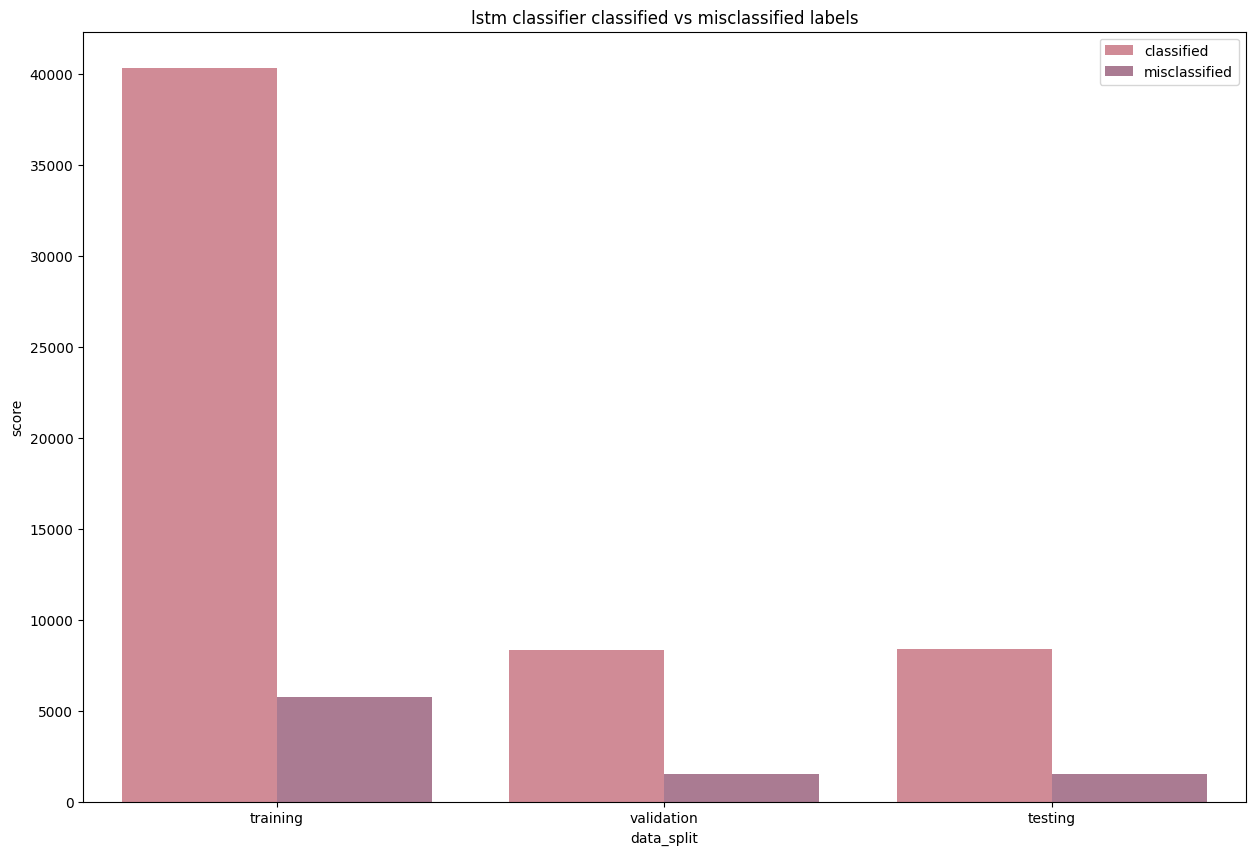

In [160]:
# visualize values of correctly classified labels in each data split
view_classified_labels(classified_df, 'lstm classifier classified vs misclassified labels')

In [161]:
# see the tangible numbers of both classified and misclassified labels for all data splits
print(f'number of correctly classified labels for the training set: {num_right_cm_train}')
print(f'number of correctly classified labels for the validation set: {num_right_cm_val}')
print(f'number of correctly classified labels for the testing set: {num_right_cm_test}')

print(f'number of correctly misclassified labels for the training set: {num_wrong_cm_train}')
print(f'number of correctly misclassified labels for the validation set: {num_wrong_cm_val}')
print(f'number of correctly misclassified labels for the testing set: {num_wrong_cm_test}')

number of correctly classified labels for the training set: 40312
number of correctly classified labels for the validation set: 8325
number of correctly classified labels for the testing set: 8361
number of correctly misclassified labels for the training set: 5734
number of correctly misclassified labels for the validation set: 1542
number of correctly misclassified labels for the testing set: 1506
